<a href="https://colab.research.google.com/github/AndrzejSADA/airbnb-nyc-analysis/blob/main/AS_AirBnB_Analiza_i_wnioski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Witamy w Colab

In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), low_memory=False)
print(f"\n✅ SUKCES, Wczytano plik: {file_name}")
df.head()

In [ ]:
# --- KROK 2: CZYSZCZENIE DANYCH ---

# 1. Standaryzacja nazw kolumn (małe litery, brak spacji)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# 2. Czyszczenie kolumn finansowych (zmiana '$966' na liczbę 966.0)
def clean_currency(value):
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', '').strip())
    return value

df['price'] = df['price'].apply(clean_currency)
df['service_fee'] = df['service_fee'].apply(clean_currency)

# 3. Naprawa literówek w dzielnicach (neighbourhood_group)
#  'brookln' czy 'manhatan'
df['neighbourhood_group'] = df['neighbourhood_group'].replace({
    'brookln': 'Brooklyn',
    'manhatan': 'Manhattan'
})

# 4. Obsługa brakujących wartości (NaN)
# uzupełniamy medianą (bezpieczniejsza niż średnia przy dużych rozpiętościach)
df['price'] = df['price'].fillna(df['price'].median())
df['service_fee'] = df['service_fee'].fillna(df['service_fee'].median())
df['neighbourhood_group'] = df['neighbourhood_group'].fillna('Unknown')

# 5. Sprawdzenie wyników
print("✅ Czyszczenie zakończone!")
print(f"Typ ceny po zmianie: {df['price'].dtype}")
print(f"Unikalne dzielnice: {df['neighbourhood_group'].unique()}")
df[['neighbourhood_group', 'price', 'service_fee']].head()

✅ Czyszczenie zakończone!
Typ ceny po zmianie: float64
Unikalne dzielnice: ['Brooklyn' 'Manhattan' 'Queens' 'Unknown' 'Staten Island' 'Bronx']


,neighbourhood_group,price,service_fee
0,Brooklyn,966.0,193.0
1,Manhattan,142.0,28.0
2,Manhattan,620.0,124.0
3,Brooklyn,368.0,74.0
4,Manhattan,204.0,41.0


/tmp/ipython-input-3940029385.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='neighbourhood_group', y='price', data=df, estimator='mean', palette='viridis')
/tmp/ipython-input-3940029385.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='price', data=df, estimator='mean', palette='magma')


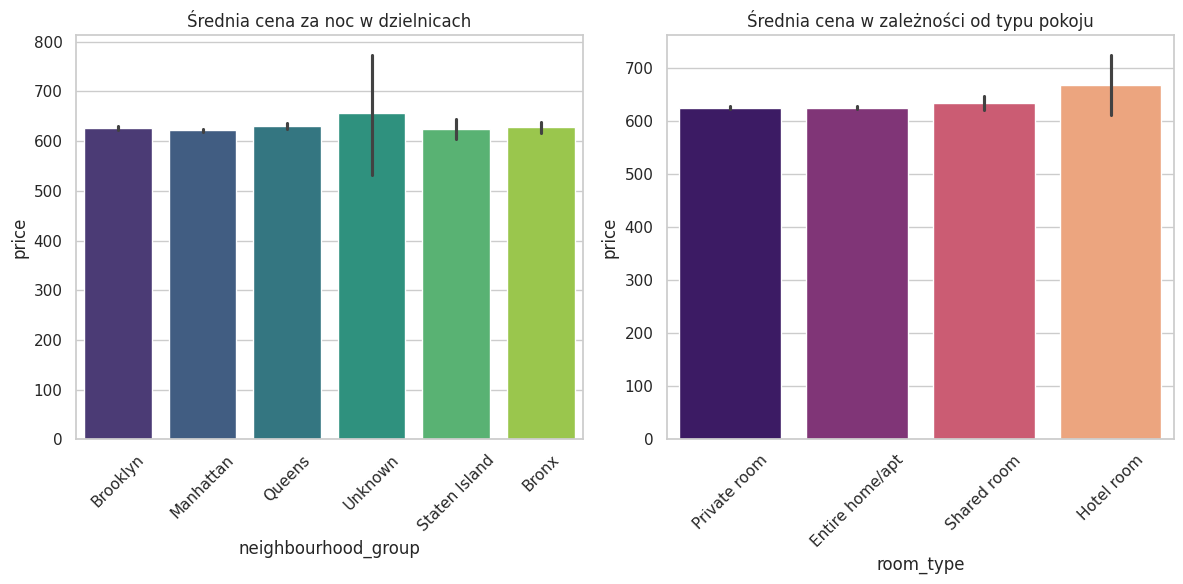

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienie stylu wykresów
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Wykres: Średnia cena w zależności od dzielnicy
plt.subplot(1, 2, 1)
sns.barplot(x='neighbourhood_group', y='price', data=df, estimator='mean', palette='viridis')
plt.title('Średnia cena za noc w dzielnicach')
plt.xticks(rotation=45)

# 2. Wykres: Średnia cena w zależności od typu pokoju
plt.subplot(1, 2, 2)
sns.barplot(x='room_type', y='price', data=df, estimator='mean', palette='magma')
plt.title('Średnia cena w zależności od typu pokoju')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

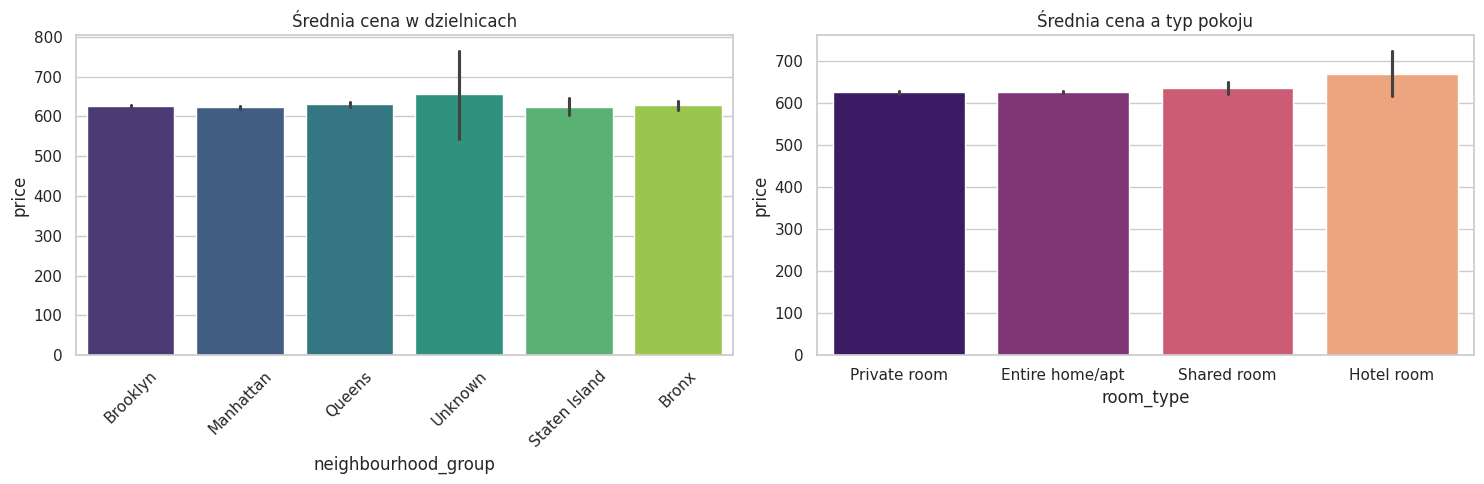

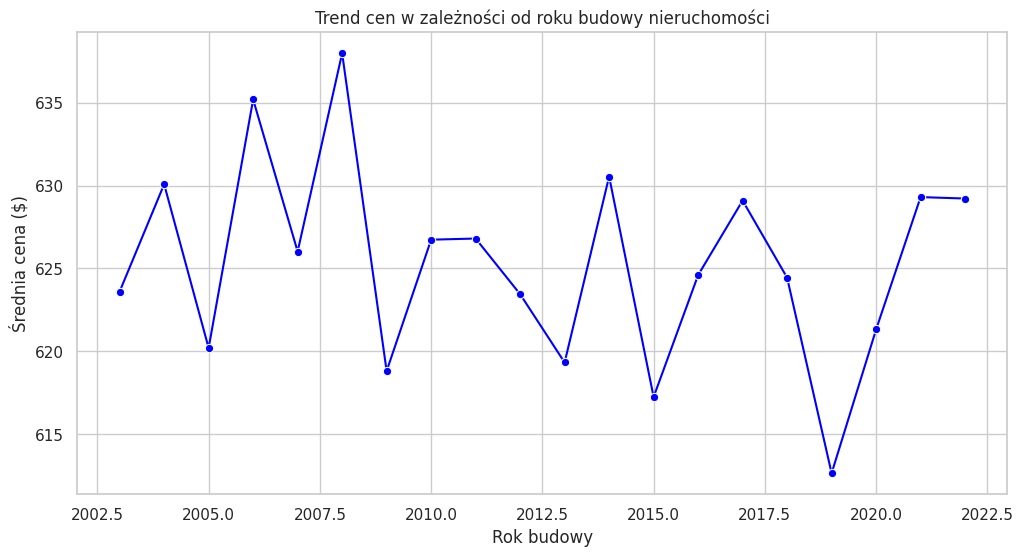

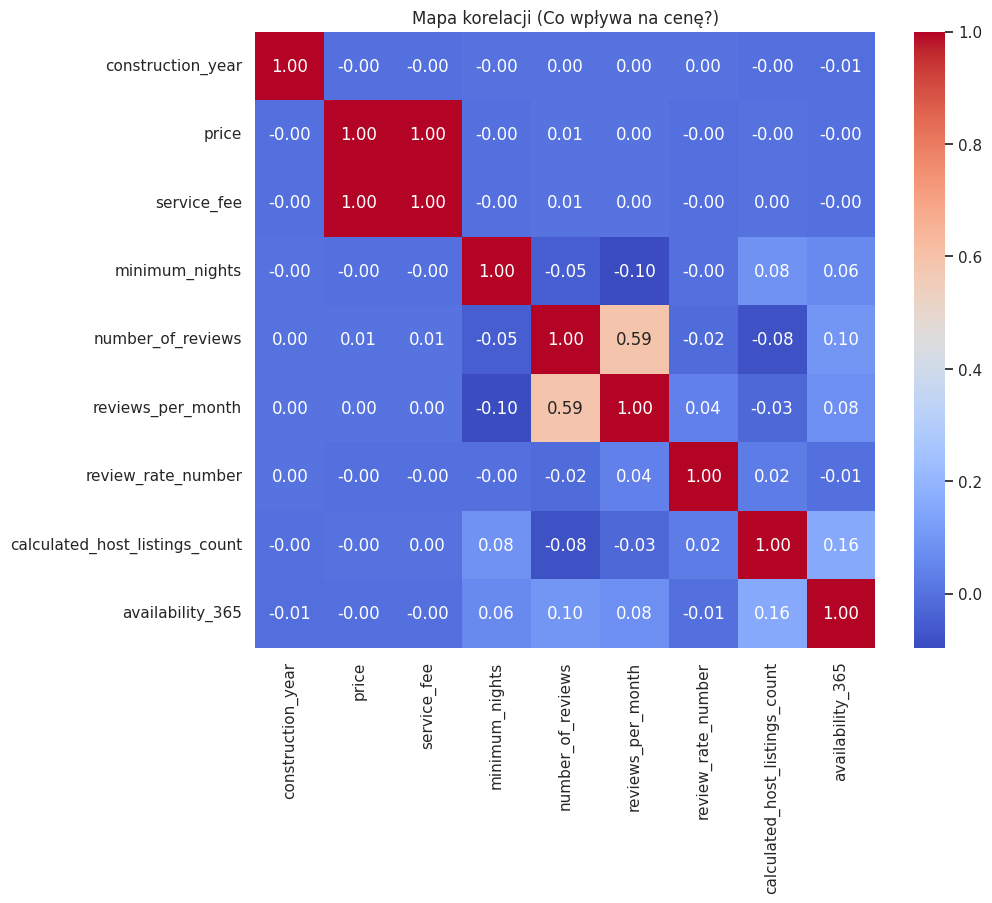

In [ ]:
# KROK 3: ZAAWANSOWANA ANALIZA

import matplotlib.pyplot as plt
import seaborn as sns

# Poprawione wykresy
plt.figure(figsize=(15, 5))

# Wykres 1: Ceny w dzielnicach
plt.subplot(1, 2, 1)
sns.barplot(x='neighbourhood_group', y='price', data=df, hue='neighbourhood_group', palette='viridis', legend=False)
plt.title('Średnia cena w dzielnicach')
plt.xticks(rotation=45)

# Wykres 2: Ceny a typ pokoju
plt.subplot(1, 2, 2)
sns.barplot(x='room_type', y='price', data=df, hue='room_type', palette='magma', legend=False)
plt.title('Średnia cena a typ pokoju')

plt.tight_layout()
plt.show()

# 2. Analiza: Czy rok budowy wpływa na cenę?
plt.figure(figsize=(12, 6))
# Grupujemy dane po roku budowy i liczymy średnią cenę
construction_trends = df.groupby('construction_year')['price'].mean().reset_index()
sns.lineplot(x='construction_year', y='price', data=construction_trends, marker='o', color='blue')
plt.title('Trend cen w zależności od roku budowy nieruchomości')
plt.xlabel('Rok budowy')
plt.ylabel('Średnia cena ($)')
plt.grid(True)
plt.show()

# 3. Macierz korelacji - sprawdzamy co naprawdę wpływa na cenę
# Wybieramy tylko kolumny liczbowe
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=['id', 'host_id', 'lat', 'long'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa korelacji (Co wpływa na cenę?)')
plt.show()

/tmp/ipython-input-351348630.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_rate_number', y='price', data=df, palette='Set3')


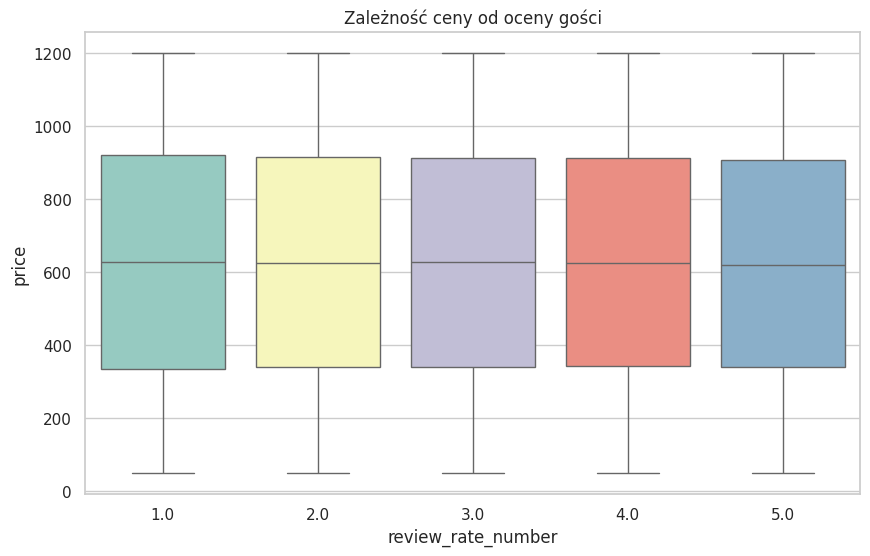

In [ ]:
# Sprawdzamy, czy lepsze oceny pozwalają dyktować wyższe ceny
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_rate_number', y='price', data=df, palette='Set3')
plt.title('Zależność ceny od oceny gości')
plt.show()

In [ ]:
# --- KROK 4: STATYSTYKI DO RAPORTU ---

# Średnia cena i liczba ofert w podziale na dzielnice
report = df.groupby('neighbourhood_group').agg({
    'price': ['mean', 'median', 'count'],
    'review_rate_number': 'mean'
}).reset_index()

# Zaokrąglamy dla lepszej czytelności
report = report.round(2)

print("TABELA DO RAPORTU: Analiza Dzielnic")
print(report)

df.to_csv('Airbnb_Cleaned_Data.csv', index=False)
print("\n✅ Plik 'Airbnb_Cleaned_Data.csv' został zapisany")

TABELA DO RAPORTU: Analiza Dzielnic
  neighbourhood_group   price               review_rate_number
                         mean median  count               mean
0               Bronx  627.76  630.5   2712               3.33
1            Brooklyn  626.56  625.0  41843               3.26
2           Manhattan  622.44  623.0  43793               3.28
3              Queens  630.19  626.0  13267               3.33
4       Staten Island  624.49  628.0    955               3.41
5             Unknown  657.17  651.0     29               3.22

✅ Plik 'Airbnb_Cleaned_Data.csv' został zapisany. Pobierz go z panelu po lewej, użyjemy go w Tableau!


TOP 10 NAJDROŻSZYCH MIKRO-DZIELNIC W NYC:
    neighbourhood_group    neighbourhood        mean  count
157              Queens    Jamaica Hills  812.904762     21
200       Staten Island    Midland Beach  796.176471     17
212       Staten Island      Shore Acres  792.260870     23
83             Brooklyn       Mill Basin  775.142857     14
34                Bronx        Riverdale  768.736842     19
11                Bronx  East Morrisania  764.666667     21
21                Bronx   Morris Heights  742.891304     46
31                Bronx       Pelham Bay  740.045455     44
27                Bronx  North Riverdale  736.250000     28
48             Brooklyn       Bath Beach  725.270833     48


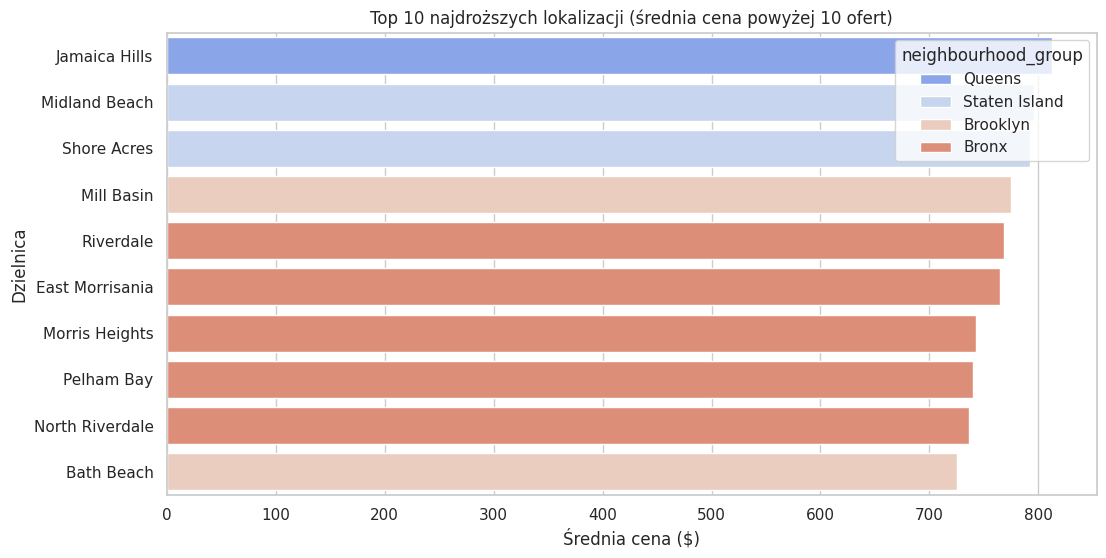

In [ ]:
# --- SZCZEGÓŁOWA ANALIZA LOKALIZACJI ---

# 1. Agregujemy dane po konkretnych sąsiedztwach
top_neighbourhoods = df.groupby(['neighbourhood_group', 'neighbourhood'])['price'].agg(['mean', 'count']).reset_index()

# 2. Odfiltrujemy te, które mają mało ofert (np. mniej niż 10), żeby wynik był wiarygodny
top_neighbourhoods = top_neighbourhoods[top_neighbourhoods['count'] > 10]

# 3. Sortujemy od najdroższych
top_10_expensive = top_neighbourhoods.sort_values(by='mean', ascending=False).head(10)

print("TOP 10 NAJDROŻSZYCH MIKRO-DZIELNIC W NYC:")
print(top_10_expensive)

# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='mean', y='neighbourhood', data=top_10_expensive, hue='neighbourhood_group', palette='coolwarm')
plt.title('Top 10 najdroższych lokalizacji (średnia cena powyżej 10 ofert)')
plt.xlabel('Średnia cena ($)')
plt.ylabel('Dzielnica')
plt.show()

WPŁYW POLITYKI ANULOWANIA NA CENĘ I OCENY:
  cancellation_policy   price  review_rate_number  number_of_listings
0            flexible  626.21                3.28               34074
1            moderate  625.05                3.28               34343
2              strict  624.57                3.28               34106


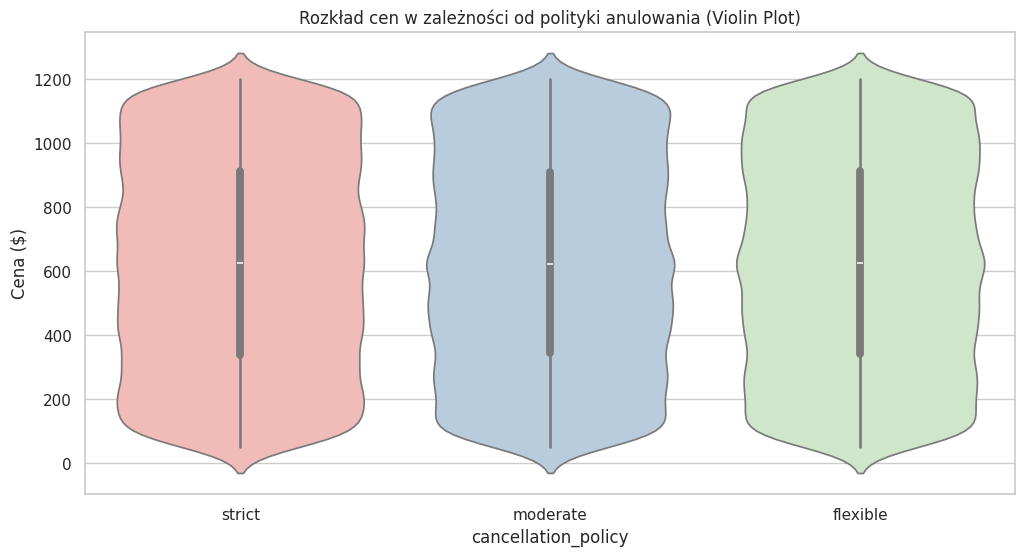

In [ ]:
# --- ANALIZA ZASAD ANULOWANIA (CANCELLATION POLICY) ---

# 1. Średnia cena i ocena w zależności od polityki anulowania
cancellation_analysis = df.groupby('cancellation_policy').agg({
    'price': 'mean',
    'review_rate_number': 'mean',
    'id': 'count'
}).rename(columns={'id': 'number_of_listings'}).reset_index()

print("WPŁYW POLITYKI ANULOWANIA NA CENĘ I OCENY:")
print(cancellation_analysis.round(2))

# 2. Wizualizacja rozkładu cen
plt.figure(figsize=(12, 6))
sns.violinplot(x='cancellation_policy', y='price', data=df, hue='cancellation_policy', palette='Pastel1', legend=False)
plt.title('Rozkład cen w zależności od polityki anulowania (Violin Plot)')
plt.ylabel('Cena ($)')
plt.show()

## Usługa Google Colab już dostępna w VS Code
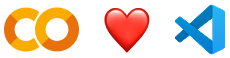

Wypróbuj nowe <a href="https://marketplace.visualstudio.com/items?itemName=Google.colab">rozszerzenie Google Colab</a> dla środowiska Visual Studio Code. Wystarczy kilka kliknięć:

*  W VS Code otwórz widok <strong><em>Rozszerzenia</em></strong> i wyszukaj „Google Colab”, aby zainstalować.
*  Otwórz selektor jądra, tworząc lub otwierając dowolny plik notatnika <code>.ipynb</code> w lokalnym obszarze roboczym i uruchamiając komórkę lub klikając przycisk <strong><em>Wybierz jądro</em></strong> w prawym górnym rogu.
*  Kliknij <strong><em>Colab</em></strong>, a następnie wybierz środowisko wykonawcze i zaloguj się na konto Google. To wszystko.

Więcej informacji znajdziesz w <a href="https://developers.googleblog.com/google-colab-is-coming-to-vs-code">tym poście na blogu</a>.

In [ ]:
!pip install numpy

## 🎁 Bezpłatny pakiet Pro z Gemini i Colab dla studentów amerykańskich uczelni 🎓

Zyskaj lepszy dostęp do naszego najdokładniejszego modelu Gemini 3 Pro. Możesz go używać przy zaawansowanym kodowaniu, złożonych badaniach i innowacyjnych projektach, korzystając ze specjalnych zasobów obliczeniowych Colab do analizy danych i uczenia maszynowego.

Skorzystaj z bezpłatnej oferty na Gemini: <a href="https://gemini.google/students?utm_source=colab&amp;utm_medium=banner&amp;utm_campaign=students_xpa_us-colab-banner">gemini.google/students</a>.  
Skorzystaj z bezpłatnej oferty Colab na stronie <a href="https://colab.research.google.com/signup">colab.research.google.com/signup</a>.  
Obowiązują warunki.

## Korzystaj z popularnych modeli AI dzięki Google-Colab-AI bez klucza interfejsu API
Wszyscy użytkownicy mogą korzystać z najpopularniejszych modeli LLM za pomocą biblioteki <code>google-colab-ai</code> języka Python, a użytkownicy wersji płatnej mają dostęp do większej liczby modeli. Dodatkowe informacje znajdziesz we <a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb">wprowadzeniu do AI w Google Colab</a>.



In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## Poznaj interfejs Gemini API
Gemini API zapewnia dostęp do modeli Gemini stworzonych przez Google DeepMind. Modele Gemini są budowane od podstaw z myślą o multimodalności, dzięki czemu mogą łatwo pracować z tekstem, obrazami, kodem i dźwiękiem.

**Jak zacząć**
*  Otwórz <a href="https://aistudio.google.com/">Google AI Studio</a> i zaloguj się na swoje konto Google.
*  <a href="https://aistudio.google.com/app/apikey">Utwórz klucz interfejsu API</a>.
* Użyj krótkiego wprowadzenia do <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb">Pythona</a> lub wywołaj interfejs API REST za pomocą <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.

**Odkryj zaawansowane możliwości Gemini**
*  Eksperymentuj z <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb">multimodalnymi wynikami</a> Gemini, mieszając tekst i obrazy w sposób iteracyjny.
*  Poznaj <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb">multimodalny interfejs Live API</a> &#40;wersja demonstracyjna <a href="https://aistudio.google.com/live">tutaj</a>&#41;.
*  Dowiedz się, jak <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb&quot;">analizować obrazy i wykrywać przedmioty na zdjęciach</a> za pomocą Gemini &#40;dodatkowo jest też <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb">wersja 3D</a>&#41;.
*  Odkryj możliwości <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb">modelu myślącego Gemini</a>, który potrafi rozwiązywać złożone zadania dzięki wewnętrznym procesom myślowym.
      
**Poznaj złożone przypadki użycia**
*  Użyj <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb">funkcji groundingu Gemini</a>, aby utworzyć raport o firmie na podstawie informacji wyszukanych przez model w internecie.
*  Wyodrębniaj <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb">faktury i dane z formularzy z plików PDF</a> w uporządkowany sposób.
*  Twórz <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb">ilustracje na podstawie całej książki</a>, korzystając z dużego okna kontekstu Gemini i Imagen.

Aby dowiedzieć się więcej, zapoznaj się ze <a href="https://github.com/google-gemini/cookbook">zbiorem Cookbook Gemini</a> lub wejdź na stronę <a href="https://ai.google.dev/docs/">dokumentacji API Gemini</a>.


Colab ma teraz funkcje AI oparte na <a href="https://gemini.google.com">Gemini</a>. Poniższy film zawiera informacje o tym, jak korzystać z tych funkcji, niezależnie od tego, czy dopiero zaczynasz przygodę z Pythonem, czy jesteś doświadczonym programistą.

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  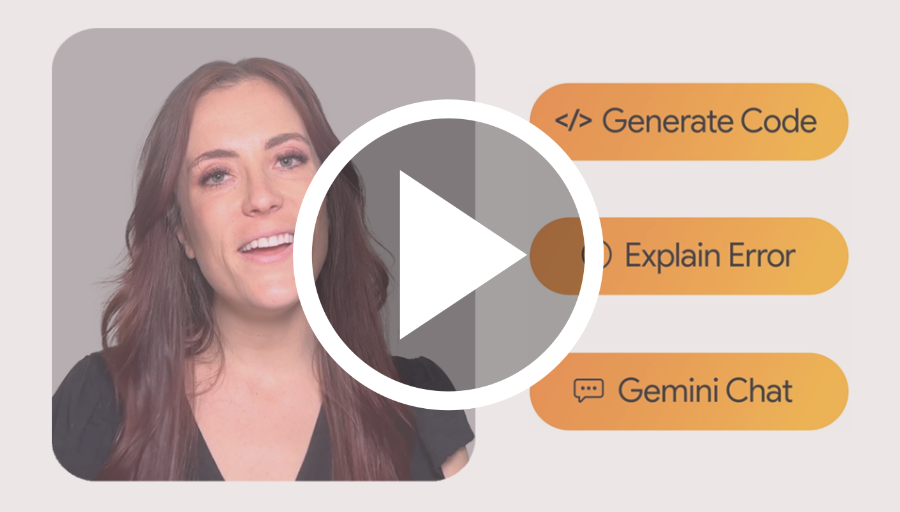
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Czym jest Colab?</h2>
</div>

Colab, lub inaczej „Colaboratory”, pozwala pisać i wykonywać kod w języku Python bezpośrednio w przeglądarce dzięki
- brakowi konieczności konfigurowania,
- Bezpłatny dostęp do GPU
- łatwemu udostępnianiu.

Colab może Ci ułatwić pracę niezależnie od tego, czy jesteś <strong>studentem</strong>, <strong>badaczem danych</strong> czy <strong>badaczem sztucznej inteligencji</strong>. Obejrzyj <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Wprowadzenie do Colab</a> lub <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y">Funkcje Colab, które mogły Ci umknąć</a>, aby dowiedzieć się więcej, lub po prostu zjedź niżej i zacznij korzystać z tej usługi.

<div class="markdown-google-sans">

## <strong>Wprowadzenie</strong>
</div>

Dokument, który właśnie czytasz, nie jest statyczną stroną internetową tylko środowiskiem interaktywnym nazywanym <strong>notatnikiem Colab</strong> umożliwiającym pisanie i uruchamianie kodu.

Na przykład to jest <strong>komórka z kodem</strong> zawierająca krótki skrypt w języku Python, który oblicza wartość, zapisuje ją w zmiennej i drukuje wynik:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

Aby uruchomić kod w komórce powyżej, zaznacz ją przez kliknięcie, a potem kliknij przycisk uruchamiania po lewej stronie kodu lub użyj skrótu klawiszowego „Command/Ctrl + Enter”. Aby rozpocząć edytowanie kodu, wystarczy tylko kliknąć komórkę.

Zmiennych zdefiniowanych w jednej komórce możesz później używać w innych komórkach:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

W notatnikach Colab możesz łączyć ze sobą <strong>kod wykonywalny</strong> i <strong>tekst sformatowany</strong> w jeden dokument razem z <strong>obrazami</strong>, <strong>kodem HTML</strong>, <strong>kodem LaTeX</strong> itd. Gdy tworzysz własne notatniki Colab, są one przechowywane na Twoim koncie Dysku Google. Notatniki te możesz z łatwością udostępniać współpracownikom i znajomym, co pozwoli im zamieszczać w nich komentarze, a nawet edytować ich zawartość. Więcej dowiesz się z artykułu <a href="/notebooks/basic_features_overview.ipynb">Omówienie Colab</a>. Aby utworzyć nowy notatnik Colab, możesz skorzystać z menu „Plik” powyżej lub z tego linku: <a href="http://colab.research.google.com#create=true">utwórz nowy notatnik Colab</a>.

Notatniki Colab są notatnikami Jupyter hostowanymi przez Colab. Więcej informacji o projekcie Jupyter znajdziesz na <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Badanie danych
</div>

Dzięki Colab możesz korzystać z wszystkich zalet popularnych bibliotek języka Python do analizowania i wizualizowania danych. Widoczna poniżej komórka z kodem korzysta z biblioteki <strong>numpy</strong> do generowania danych losowych oraz z biblioteki <strong>matplotlib</strong> do ich wizualizacji. Aby rozpocząć edytowanie kodu, wystarczy tylko kliknąć komórkę.

Do notatników Colab możesz importować własne dane z konta Dysku Google &#40;m.in. arkusze kalkulacyjne&#41; oraz z usługi GitHub i wielu innych źródeł. Aby dowiedzieć się więcej o importowaniu danych i sposobach użycia Colab do ich badania, skorzystaj z linków poniżej w sekcji <a href="#working-with-data">Praca z danymi</a>.

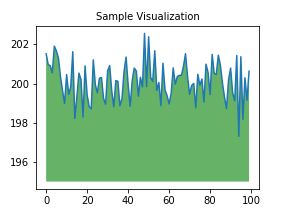

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Ustawienia wymiarów (90x50mm przy 300 DPI)
width, height = 1063, 591
bg_color = (255, 255, 255)  # Białe tło

# Tworzenie czystego obrazu
img = Image.new('RGB', (width, height), color=bg_color)
draw = ImageDraw.Draw(img)

# Próba załadowania czcionki (możesz zmienić ścieżkę do własnej czcionki .ttf)
try:
    font_bold = ImageFont.truetype("arialbd.ttf", 45)
    font_reg = ImageFont.truetype("arial.ttf", 30)
    font_small = ImageFont.truetype("arial.ttf", 25)
except:
    font_bold = ImageFont.load_default()
    font_reg = ImageFont.load_default()
    font_small = ImageFont.load_default()

# --- LEWA STRONA ---
# Nazwa firmy i osoba
draw.text((60, 250), "SUPERBIA", fill=(0, 0, 0), font=font_bold)
draw.text((60, 310), "HELENA KONDRATOWICZ", fill=(100, 100, 100), font=font_reg)

# Usługi
draw.text((60, 380), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=font_small)
draw.text((60, 415), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=font_small)

# NIP na dole
draw.text((60, 500), "NIP 5242888084", fill=(0, 0, 0), font=font_small)

# --- PRAWA STRONA ---
# Dane kontaktowe (wyrównane do prawej lub w bloku)
x_right = 600
draw.text((x_right, 100), "WŁAŚCICIEL", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 180), "Tel: +48 517 485 004", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 230), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=font_reg)

# Adres
draw.text((x_right, 310), "00-406 Warszawa", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 350), "ul. Ludna 2/705", fill=(0, 0, 0), font=font_reg)

# Zapisywanie pliku
img.save("wizytowka_helena_final.png")
print("Wizytówka została wygenerowana jako plik: wizytowka_helena_final.png")

Wizytówka została wygenerowana jako plik: wizytowka_helena_final.png


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def stworz_wizytowke():
    # 1. PARAMETRY (90x50mm przy 300 DPI)
    width, height = 1063, 591
    img = Image.new('RGB', (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    # 2. CZCIONKI (Używamy Arial lub domyślnej)
    try:
        font_bold = ImageFont.truetype("arialbd.ttf", 40)
        font_reg = ImageFont.truetype("arial.ttf", 28)
        font_small = ImageFont.truetype("arial.ttf", 22)
    except:
        font_bold = font_reg = font_small = ImageFont.load_default()

    # 3. WYCINANIE LOGO Z ORYGINAŁU
    try:
        oryginal = Image.open("oryginal.png")
        # Wycinamy obszar loga: sygnet + napis + czerwona linia
        # Współrzędne (lewo, góra, prawo, dół) - dopasuj jeśli trzeba
        logo_crop = oryginal.crop((50, 250, 400, 780))
        logo_crop.thumbnail((350, 350)) # Skalowanie loga
        img.paste(logo_crop, (60, 50))
    except Exception as e:
        print(f"Błąd ładowania logo: {e}. Upewnij się, że plik nazywa się oryginal.png")

    # 4. TEKST - LEWA STRONA (pod logo)
    draw.text((60, 380), "HELENA KONDRATOWICZ", fill=(0, 0, 0), font=font_reg)
    draw.text((60, 430), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=font_small)
    draw.text((60, 460), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=font_small)
    draw.text((60, 520), "NIP 5242888084", fill=(0, 0, 0), font=font_small)

    # 5. TEKST - PRAWA STRONA
    x_right = 600
    draw.text((x_right, 150), "WŁAŚCICIEL", fill=(0, 0, 0), font=font_bold)
    draw.text((x_right, 230), "Tel: +48 517 485 004", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 280), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=font_reg)

    # Adres: kod i miasto najpierw
    draw.text((x_right, 360), "00-406 Warszawa", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 400), "ul. Ludna 2/705", fill=(0, 0, 0), font=font_reg)

    # 6. ZAPIS
    img.save("wizytowka_gotowa_do_druku.png")
    print("Sukces! Plik wizytowka_gotowa_do_druku.png został utworzony.")

if __name__ == "__main__":
    stworz_wizytowke()

Błąd ładowania logo: [Errno 2] No such file or directory: 'oryginal.png'. Upewnij się, że plik nazywa się oryginal.png
Sukces! Plik wizytowka_gotowa_do_druku.png został utworzony.


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def stworz_wizytowke():
    # 1. PARAMETRY (standard 90x50mm przy 300 DPI)
    width, height = 1063, 591
    img = Image.new('RGB', (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    # 2. CZCIONKI
    try:
        # Upewnij się, że masz te pliki w folderze lub użyj ścieżki systemowej
        font_name = ImageFont.truetype("arialbd.ttf", 42)
        font_bold = ImageFont.truetype("arialbd.ttf", 36)
        font_reg = ImageFont.truetype("arial.ttf", 28)
        font_small = ImageFont.truetype("arial.ttf", 22)
    except:
        font_name = font_bold = font_reg = font_small = ImageFont.load_default()

    # 3. LOGO (Sygnet)
    try:
        oryginal = Image.open("oryginal.png")
        # Wycinamy sam sygnet (grafikę bez napisów), aby wkleić ją czysto
        logo_sygnet = oryginal.crop((80, 260, 320, 520))
        logo_sygnet.thumbnail((200, 200), Image.Resampling.LANCZOS)
        img.paste(logo_sygnet, (110, 60))
    except Exception as e:
        print(f"Błąd logo: {e}. Upewnij się, że masz plik oryginal.png")

    # 4. LEWA STRONA - Nazwa i Usługi
    draw.text((60, 280), "SUPERBIA", fill=(0, 0, 0), font=font_name)
    # Rysowanie czerwonej linii (idealnie prostej)
    draw.line((60, 335, 360, 335), fill=(200, 0, 0), width=4)

    draw.text((60, 350), "HELENA KONDRATOWICZ", fill=(80, 80, 80), font=font_reg)

    # Usługi pod spodem
    draw.text((60, 420), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=font_small)
    draw.text((60, 455), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=font_small)

    # NIP na samym dole
    draw.text((60, 520), "NIP 5242888084", fill=(0, 0, 0), font=font_small)

    # 5. PRAWA STRONA - Kontakt
    x_right = 580
    draw.text((x_right, 140), "WŁAŚCICIEL", fill=(0, 0, 0), font=font_bold)

    draw.text((x_right, 220), "Tel: +48 517 485 004", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 270), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=font_reg)

    # Adres (zgodnie z prośbą: kod i miasto najpierw)
    draw.text((x_right, 350), "00-406 Warszawa", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 390), "ul. Ludna 2/705", fill=(0, 0, 0), font=font_reg)

    # 6. ZAPIS
    img.save("wizytowka_do_druku_v2.png", quality=100)
    print("Sukces! Plik wizytowka_do_druku_v2.png został utworzony.")

if __name__ == "__main__":
    stworz_wizytowke()

Błąd logo: [Errno 2] No such file or directory: 'oryginal.png'. Upewnij się, że masz plik oryginal.png
Sukces! Plik wizytowka_do_druku_v2.png został utworzony.


In [ ]:
import os
import shutil
from PIL import Image, ImageDraw, ImageFont

# 1. POSZUKIWANIE PLIKU (Metoda automatyczna)
znaleziono = False
for root, dirs, files in os.walk('/content/'):
    if 'oryginal.png' in files:
        sciezka_zrodlowa = os.path.join(root, 'oryginal.png')
        shutil.copy(sciezka_zrodlowa, '/content/logo_do_uzycia.png')
        print(f"Sukces! Znalazłem logo w: {sciezka_zrodlowa} i skopiowałem je.")
        znaleziono = True
        break

if not znaleziono:
    print("BŁĄD: Plik 'oryginal.png' wyparował. Wgraj go jeszcze raz bezpośrednio do panelu po lewej.")

# 2. GENEROWANIE WIZYTÓWKI
def stworz_wizytowke():
    width, height = 1063, 591
    img = Image.new('RGB', (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    try:
        font_name = ImageFont.truetype("arialbd.ttf", 42)
        font_bold = ImageFont.truetype("arialbd.ttf", 36)
        font_reg = ImageFont.truetype("arial.ttf", 28)
        font_small = ImageFont.truetype("arial.ttf", 22)
    except:
        font_name = font_bold = font_reg = font_small = ImageFont.load_default()

    # Wstawianie logo
    if os.path.exists('/content/logo_do_uzycia.png'):
        oryginal = Image.open('/content/logo_do_uzycia.png')
        # Wycinamy sygnet (dopasowane współrzędne)
        logo_sygnet = oryginal.crop((80, 260, 320, 520))
        logo_sygnet.thumbnail((200, 200), Image.Resampling.LANCZOS)
        img.paste(logo_sygnet, (110, 60))

    # Dane (zgodnie z Twoimi ustaleniami)
    draw.text((60, 280), "SUPERBIA", fill=(0, 0, 0), font=font_name)
    draw.line((60, 335, 360, 335), fill=(200, 0, 0), width=4)
    draw.text((60, 350), "HELENA KONDRATOWICZ", fill=(80, 80, 80), font=font_reg)
    draw.text((60, 420), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=font_small)
    draw.text((60, 455), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=font_small)
    draw.text((60, 520), "NIP 5242888084", fill=(0, 0, 0), font=font_small)

    x_right = 580
    draw.text((x_right, 140), "WŁAŚCICIEL", fill=(0, 0, 0), font=font_bold)
    draw.text((x_right, 220), "Tel: +48 517 485 004", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 270), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 350), "00-406 Warszawa", fill=(0, 0, 0), font=font_reg)
    draw.text((x_right, 390), "ul. Ludna 2/705", fill=(0, 0, 0), font=font_reg)

    img.save("wizytowka_finalna.png", quality=100)
    print("Wizytówka gotowa!")

stworz_wizytowke()

BŁĄD: Plik 'oryginal.png' wyparował. Wgraj go jeszcze raz bezpośrednio do panelu po lewej.
Wizytówka gotowa!


In [ ]:
import os
import shutil
from PIL import Image, ImageDraw, ImageFont
from google.colab import files

# 1. AUTOMATYCZNE POSZUKIWANIE LOGO
plik_logo = "oryginal.png"
sciezka_tymczasowa = "/content/logo_do_uzycia.png"
znaleziono = False

for root, dirs, files_list in os.walk('/'): # Przeszukuje cały system
    if plik_logo in files_list:
        sciezka_zrodlowa = os.path.join(root, plik_logo)
        shutil.copy(sciezka_zrodlowa, sciezka_tymczasowa)
        print(f"Sukces! Logo znalezione w: {sciezka_zrodlowa}")
        znaleziono = True
        break

if not znaleziono:
    print("BŁĄD: Nadal nie widzę pliku 'oryginal.png'. Wgraj go ponownie bezpośrednio do panelu 'Pliki' po lewej.")
else:
    # 2. GENEROWANIE WIZYTÓWKI
    def stworz_wizytowke():
        width, height = 1063, 591
        img = Image.new('RGB', (width, height), color=(255, 255, 255))
        draw = ImageDraw.Draw(img)

        # Ustawienia czcionek
        try:
            f_bold = ImageFont.truetype("arialbd.ttf", 40)
            f_reg = ImageFont.truetype("arial.ttf", 28)
            f_small = ImageFont.truetype("arial.ttf", 22)
        except:
            f_bold = f_reg = f_small = ImageFont.load_default()

        # Wklejanie logo (wycinanie sygnetu)
        logo_raw = Image.open(sciezka_tymczasowa)
        logo_sygnet = logo_raw.crop((80, 260, 320, 520))
        logo_sygnet.thumbnail((200, 200), Image.Resampling.LANCZOS)
        img.paste(logo_sygnet, (110, 60))

        # Dane firmy i właściciela (zgodnie z Twoją prośbą)
        draw.text((60, 280), "SUPERBIA", fill=(0, 0, 0), font=f_bold)
        draw.line((60, 335, 360, 335), fill=(200, 0, 0), width=4) # Czerwona linia
        draw.text((60, 350), "HELENA KONDRATOWICZ", fill=(80, 80, 80), font=f_reg)
        draw.text((60, 420), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=f_small)
        draw.text((60, 455), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=f_small)
        draw.text((60, 520), "NIP 5242888084", fill=(0, 0, 0), font=f_small)

        # Dane kontaktowe (Prawa strona)
        xr = 580
        draw.text((xr, 140), "WŁAŚCICIEL", fill=(0, 0, 0), font=f_bold)
        draw.text((xr, 220), "Tel: +48 517 485 004", fill=(0, 0, 0), font=f_reg)
        draw.text((xr, 270), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=f_reg)
        draw.text((xr, 350), "00-406 Warszawa", fill=(0, 0, 0), font=f_reg)
        draw.text((xr, 390), "ul. Ludna 2/705", fill=(0, 0, 0), font=f_reg)

        # Zapis i automatyczne pobieranie
        nazwa_pliku = "wizytowka_helena_final.png"
        img.save(nazwa_pliku, quality=100)
        print("Wizytówka wygenerowana! Zaraz rozpocznie się pobieranie...")
        files.download(nazwa_pliku)

    stworz_wizytowke()

Sukces! Logo znalezione w: /tools/oryginal.png
Wizytówka wygenerowana! Zaraz rozpocznie się pobieranie...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Ustawienia wymiarów (90x50mm przy 300 DPI)
width, height = 1063, 591
bg_color = (255, 255, 255)  # Białe tło

# Tworzenie czystego obrazu
img = Image.new('RGB', (width, height), color=bg_color)
draw = ImageDraw.Draw(img)

# Próba załadowania czcionki (możesz zmienić ścieżkę do własnej czcionki .ttf)
try:
    font_bold = ImageFont.truetype("arialbd.ttf", 45)
    font_reg = ImageFont.truetype("arial.ttf", 30)
    font_small = ImageFont.truetype("arial.ttf", 25)
except:
    font_bold = ImageFont.load_default()
    font_reg = ImageFont.load_default()
    font_small = ImageFont.load_default()

# --- LEWA STRONA ---
# Nazwa firmy i osoba
draw.text((60, 250), "SUPERBIA", fill=(0, 0, 0), font=font_bold)
draw.text((60, 310), "HELENA KONDRATOWICZ", fill=(100, 100, 100), font=font_reg)

# Usługi
draw.text((60, 380), "Legalizacja pobytu i pracy cudzoziemców w Polsce", fill=(50, 50, 50), font=font_small)
draw.text((60, 415), "Легализация пребывания и работы в Польше", fill=(50, 50, 50), font=font_small)

# NIP na dole
draw.text((60, 500), "NIP 5242888084", fill=(0, 0, 0), font=font_small)

# --- PRAWA STRONA ---
# Dane kontaktowe (wyrównane do prawej lub w bloku)
x_right = 600
draw.text((x_right, 100), "WŁAŚCICIEL", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 180), "Tel: +48 517 485 004", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 230), "E-mail: kondratowicz0108@gmail.com", fill=(0, 0, 0), font=font_reg)

# Adres
draw.text((x_right, 310), "00-406 Warszawa", fill=(0, 0, 0), font=font_reg)
draw.text((x_right, 350), "ul. Ludna 2/705", fill=(0, 0, 0), font=font_reg)

# Zapisywanie pliku
img.save("wizytowka_helena_final.png")
print("Wizytówka została wygenerowana jako plik: wizytowka_helena_final.png")

Wizytówka została wygenerowana jako plik: wizytowka_helena_final.png


In [ ]:
import os

def generuj_szablon_z_logo():
    print("--- Generowanie Uniwersalnego Szablonu z Logo ---")

    # Dane do wypełnienia
    imie = "____________________"
    stanowisko = "________________________________________"
    haslo = "__________________________________________________"
    # Tutaj wstawisz link do swojego logo (np. z Imgur lub Twojego serwera)
    logo_url = "https://via.placeholder.com/150x50?text=TWOJE+LOGO"

    html_template = f'''
    <!DOCTYPE html>
    <html lang="pl">
    <head>
        <meta charset="UTF-8">
        <title>Szablon Wizytówki z Logo</title>
        <style>
            body {{ font-family: 'Segoe UI', sans-serif; background-color: #f4f7f6; color: #333; line-height: 1.6; padding: 40px; }}
            .card {{ max-width: 700px; margin: auto; background: white; border-radius: 15px; overflow: hidden; box-shadow: 0 10px 30px rgba(0,0,0,0.1); border-top: 8px solid #0077b5; }}
            .content {{ padding: 30px; }}

            /* Sekcja Logo */
            .logo-container {{ text-align: left; margin-bottom: 20px; }}
            .logo-container img {{ max-height: 60px; width: auto; }}

            h1 {{ color: #0077b5; margin: 0; font-size: 2.2em; border-bottom: 2px solid #eee; padding-bottom: 10px; }}
            h2 {{ color: #666; font-weight: 300; margin-top: 15px; margin-bottom: 20px; }}
            .quote {{ font-style: italic; color: #888; border-left: 3px solid #0077b5; padding-left: 15px; margin: 20px 0; }}
            .project-box {{ background: #f9f9f9; padding: 15px; border-radius: 8px; margin-bottom: 15px; border: 1px dashed #ccc; }}
            .highlight {{ color: #0077b5; font-weight: bold; }}
            .footer {{ text-align: center; padding: 20px; font-size: 0.8em; color: #bbb; }}
            .label {{ font-size: 0.7em; color: #aaa; text-transform: uppercase; display: block; }}
        </style>
    </head>
    <body>
        <div class="card">
            <div class="content">
                <div class="logo-container">
                    <img src="{logo_url}" alt="Logo Firmy">
                </div>

                <span class="label">Imię i Nazwisko</span>
                <h1>{imie}</h1>

                <span class="label">Specjalizacja / Stanowisko</span>
                <h2>{stanowisko}</h2>

                <span class="label">Motto zawodowe</span>
                <div class="quote">"{haslo}"</div>

                <h3>Portfolio Projektów:</h3>
                <div class="project-box">
                    <span class="highlight">PROJEKT #1:</span> __________________________________________________
                </div>

                <hr style="border: 0; border-top: 1px solid #eee; margin: 25px 0;">

                <p>📬 <b>Kontakt:</b> ____________________</p>
                <p>🔗 <b>LinkedIn:</b> ____________________</p>
            </div>
            <div class="footer">Silnik wizytówek v1.1 | Obsługa logotypów</div>
        </div>
    </body>
    </html>
    '''

    ścieżka_zapisu = "/home/AndrzejSADA/mysite/templates/index.html"
    os.makedirs(os.path.dirname(ścieżka_zapisu), exist_ok=True)

    with open(ścieżka_zapisu, "w", encoding="utf-8") as f:
        f.write(html_template)

    print(f"✅ Szablon z logo został zapisany!")

if __name__ == "__main__":
    generuj_szablon_z_logo()

--- Generowanie Uniwersalnego Szablonu z Logo ---
✅ Szablon z logo został zapisany!


In [ ]:
# ==============================================================================
# INSTRUKCJA DLA UŻYTKOWNIKA:
# 1. Ten skrypt należy uruchomić w środowisku Google Colab.
# 2. Po uruchomieniu kliknij przycisk "Wybierz pliki", aby wgrać swoje LOGO.
# 3. Gotowy szablon HTML z kreskami zostanie automatycznie pobrany na Twój dysk.
# ==============================================================================

import os
import base64

# Sprawdzenie czy skrypt działa w Colabie i import specyficznych narzędzi
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print("⚠️ Uwaga: Skrypt nie został wykryty w Google Colab. Niektóre funkcje (upload/download) mogą nie działać.")

def generuj_szablon_wizytowki_colab():
    if not IN_COLAB:
        print("❌ Błąd: Uruchom ten kod w Google Colab, aby skorzystać z funkcji przesyłania plików.")
        return

    print("--- 🚀 START: Kreator Szablonu Wizytówki (Ver. Colab) ---")

    # KROK 1: Przesyłanie Logo
    print("\n[KROK 1] Prześlij plik logo z komputera (np. JPG lub PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("💡 Nie wybrano pliku. Szablon zostanie wygenerowany z miejscem na logo.")
        logo_src = "https://via.placeholder.com/150x50?text=TWOJE+LOGO"
    else:
        # Pobranie nazwy pierwszego wgranego pliku
        nazwa_pliku = list(uploaded.keys())[0]
        with open(nazwa_pliku, "rb") as f:
            encoded_string = base64.b64encode(f.read()).decode('utf-8')
            # Rozpoznawanie formatu pliku (jpg/png)
            rozszerzenie = nazwa_pliku.split('.')[-1].lower()
            logo_src = f"data:image/{rozszerzenie};base64,{encoded_string}"

    # KROK 2: Definicja danych (Uniwersalne kreski)
    imie = "____________________"
    firma = "____________________"
    stanowisko = "________________________________________"
    email = "____________________"
    linkedin = "____________________"

    # KROK 3: Szablon HTML
    html_template = f'''
    <!DOCTYPE html>
    <html lang="pl">
    <head>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: 'Segoe UI', Arial, sans-serif; background-color: #f0f2f5; display: flex; justify-content: center; align-items: center; height: 100vh; margin: 0; }}
            .card {{ width: 480px; background: white; border-radius: 15px; box-shadow: 0 15px 35px rgba(0,0,0,0.15); padding: 35px; border-left: 10px solid #0077b5; }}
            .logo-section {{ margin-bottom: 5px; }}
            .logo-section img {{ max-height: 60px; max-width: 200px; }}
            .company-name {{
                font-size: 1.1em; font-weight: bold; color: #444;
                display: inline-block; border-bottom: 4px solid #8B0000; /* Ciemnoczerwony akcent */
                padding-bottom: 5px; margin-bottom: 25px; text-transform: uppercase;
            }}
            h1 {{ color: #0077b5; margin: 0; font-size: 2em; }}
            .job {{ color: #777; font-size: 1.2em; margin-top: 5px; margin-bottom: 30px; }}
            .contact {{ border-top: 1px solid #eee; padding-top: 20px; font-size: 0.9em; }}
            .contact-row {{ margin-bottom: 10px; color: #555; }}
            .tag {{ color: #aaa; font-size: 0.7em; text-transform: uppercase; margin-right: 15px; font-weight: bold; }}
        </style>
    </head>
    <body>
        <div class="card">
            <div class="logo-section"><img src="{logo_src}"></div>
            <div class="company-name">{firma}</div>
            <h1>{imie}</h1>
            <div class="job">{stanowisko}</div>
            <div class="contact">
                <div class="contact-row"><span class="tag">Email</span>{email}</div>
                <div class="contact-row"><span class="tag">LinkedIn</span>{linkedin}</div>
            </div>
        </div>
    </body>
    </html>
    '''

    # KROK 4: Zapis i pobieranie
    nazwa_wynikowa = "uniwersalna_wizytowka.html"
    with open(nazwa_wynikowa, "w", encoding="utf-8") as f:
        f.write(html_template)

    print(f"\n✅ Gotowe! Pobieram plik: {nazwa_wynikowa}")
    files.download(nazwa_wynikowa)

# Odpalenie funkcji
if __name__ == "__main__":
    generuj_szablon_wizytowki_colab()

--- 🚀 START: Kreator Szablonu Wizytówki (Ver. Colab) ---

[KROK 1] Prześlij plik logo z komputera (np. JPG lub PNG):


Saving Andrzej .pdf to Andrzej .pdf

✅ Gotowe! Pobieram plik: uniwersalna_wizytowka.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def generuj_wizytowke():
    print("--- Generator Wizytówek v1.0 ---")
    imie = input("Podaj imię i nazwisko: ")
    stanowisko = input("Podaj stanowisko (np. Junior Data Analyst): ")
    projekt1 = input("Opisz swój pierwszy projekt (np. Airbnb NYC): ")
    projekt2 = input("Opisz swój drugi projekt (np. Flota Prius): ")
    email = input("Podaj swój email kontaktowy: ")

    html_template = f'''
    <html>
    <body style="font-family: Arial; padding: 50px; background: #f0f2f5;">
        <div style="background: white; padding: 20px; border-left: 5px solid #0077b5;">
            <h1>{imie}</h1>
            <p><b>Stanowisko:</b> {stanowisko}</p>
            <hr>
            <h3>Moje realizacje:</h3>
            <ul>
                <li>{projekt1}</li>
                <li>{projekt2}</li>
            </ul>
            <p>Kontakt: <a href="mailto:{email}">{email}</a></p>
        </div>
    </body>
    </html>
    '''

    with open("moja_wizytowka.html", "w", encoding="utf-8") as f:
        f.write(html_template)

    print("\n✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.")

if __name__ == "__main__":
    generuj_wizytowke()

--- Generator Wizytówek v1.0 ---
Podaj imię i nazwisko: and
Podaj stanowisko (np. Junior Data Analyst): annd
Opisz swój pierwszy projekt (np. Airbnb NYC): nanns
Opisz swój drugi projekt (np. Flota Prius): nanns
Podaj swój email kontaktowy: aa@wp.pl

✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.


In [ ]:
# ==============================================================================
# INTERAKTYWNY GENERATOR WIZYTÓWKI PNG (Wersja Colab)
# ==============================================================================

# 1. Instalacja niezbędnych narzędzi (wykonywana tylko raz na sesję)
!pip install html2image -q
!apt-get update -q
!apt-get install -y chromium-browser -q

import base64
from google.colab import files
from html2image import Html2Image

def interaktywny_generator_wizytowek():
    hti = Html2Image(browser='chromium', custom_flags=['--no-sandbox', '--disable-dev-shm-usage'])

    print("--- 🚀 START: Kreator Wizytówki Firmowej v2.0 ---")

    # KROK 1: Przesyłanie Logo
    print("\n[KROK 1] Wybierz plik logo (JPG/PNG) ze swojego dysku:")
    uploaded = files.upload()

    if not uploaded:
        print("💡 Nie wybrano pliku. Używam domyślnego pola.")
        logo_src = "https://via.placeholder.com/150x80?text=LOGO"
    else:
        nazwa_pliku = list(uploaded.keys())[0]
        with open(nazwa_pliku, "rb") as f:
            enc = base64.b64encode(f.read()).decode('utf-8')
            ext = nazwa_pliku.split('.')[-1].lower()
            logo_src = f"data:image/{ext};base64,{enc}"

    # KROK 2: Pobieranie danych od użytkownika (ZATRZYMANIE SKRYPTU)
    print("\n[KROK 2] Wprowadź dane do wizytówki:")

    nazwa_firmy   = input("Nazwa firmy: ")
    kolor_linii   = input("Kolor linii (np. #8B0000 dla ciemnoczerwonego): ") or "#8B0000"
    grubosc_linii = input("Grubość linii w px (np. 4): ") or "4"

    imie_nazwisko = input("Podaj imię i nazwisko: ")
    kod_miasto    = input("Kod pocztowy i Miasto: ")
    ulica         = input("Ulica i numer (bez 'ul.'): ")
    opis_uslugi   = input("Opis (np. usługi ślusarskie): ")
    nip_cyfry     = input("NIP (same cyfry): ")
    email_user    = input("Podaj email (domyślnie: aa@wp.pl): ") or "aa@wp.pl"

    # KROK 3: Szablon HTML (Projekt wizytówki)
    html_content = f'''
    <div id="card" style="width: 550px; background: white; padding: 35px; font-family: 'Segoe UI', Arial, sans-serif; border: 1px solid #ddd; display: flex; align-items: flex-start;">

        <div style="width: 150px; flex-shrink: 0; margin-right: 25px;">
            <img src="{logo_src}" style="max-width: 100%; max-height: 100px; display: block;">
        </div>

        <div style="flex-grow: 1;">
            <div style="font-size: 1.5em; font-weight: bold; color: #333; text-transform: uppercase; line-height: 1.1;">
                {nazwa_firmy}
            </div>

            <div style="width: 100%; height: {grubosc_linii}px; background-color: {kolor_linii}; margin: 10px 0 20px 0;"></div>

            <div style="font-size: 1.3em; font-weight: bold; color: #0077b5; margin-bottom: 10px;">
                {imie_nazwisko}
            </div>

            <div style="font-size: 1em; color: #444; line-height: 1.4;">
                {kod_miasto}<br>
                ul. {ulica}<br>
                <span style="font-weight: bold; color: #000;">{opis_uslugi}</span>
            </div>

            <div style="margin-top: 20px; font-size: 0.9em; color: #666; border-top: 1px solid #eee; padding-top: 12px;">
                NIP: {nip_cyfry}<br>
                Email: <span style="color: #0077b5;">{email_user}</span>
            </div>
        </div>
    </div>
    '''

    # KROK 4: Generowanie obrazu PNG
    nazwa_pliku_png = "wizytowka_gotowa.png"
    # Renderujemy tylko obszar #card
    hti.screenshot(html_str=html_content, save_as=nazwa_pliku_png, size=(650, 420))

    print(f"\n✅ Gotowe! Plik '{nazwa_pliku_png}' został wygenerowany.")
    files.download(nazwa_pliku_png)

# Uruchomienie programu
if __name__ == "__main__":
    interaktywny_generator_wizytowek()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...^C
Reading package lists...
Building dependency tree...
Reading state information...
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
^C
--- 🚀 START: Kreator Wizytówki Firmowej v2.0 ---

[KROK 1] Wybierz plik logo (JPG/PNG) ze swojego dysku:


KeyboardInterrupt: 

In [ ]:
import base64
from google.colab import files

def generuj_wizytowke():
    print("--- Generator Wizytówek Firmowych v2.0 ---")

    # 1. Pobieranie logo ze wskazaniem pliku
    print("\n[KROK 1] Wybierz plik logo (JPG/PNG):")
    uploaded = files.upload()
    if uploaded:
        nazwa_pliku = list(uploaded.keys())[0]
        with open(nazwa_pliku, "rb") as f:
            encoded_string = base64.b64encode(f.read()).decode('utf-8')
            logo_src = f"data:image/png;base64,{encoded_string}"
    else:
        logo_src = ""

    # 2. Interaktywne wpisywanie danych (Zatrzymanie skryptu)
    print("\n[KROK 2] Wprowadź dane:")

    nazwa_firmy = input("Nazwa firmy: ")
    kolor_linii = input("Kolor linii podkreślenia (np. #8B0000 lub red): ") or "#8B0000"
    grubosc_linii = input("Grubość linii (np. 3px): ") or "3px"

    imie = input("Podaj imię i nazwisko: ")
    kod_miasto = input("adres kod:    Miasto: ")
    ul_dane = input("ul: ") # Tu wpisujesz tylko np. Nowodworska 35
    opis = input("Opis (np. usługi ślusarskie): ")
    nip_cyfry = input("NIP (same cyfry): ")
    email = input("Podaj swój email kontaktowy (domyślnie aa@wp.pl): ") or "aa@wp.pl"

    # 3. Szablon HTML z logiem po lewej i stałymi elementami
    html_template = f'''
    <html>
    <head>
        <meta charset="UTF-8">
    </head>
    <body style="font-family: Arial, sans-serif; padding: 50px; background: #f0f2f5;">
        <div style="background: white; padding: 30px; width: 600px; display: flex; border: 1px solid #ccc; box-shadow: 5px 5px 15px rgba(0,0,0,0.1);">

            <div style="flex: 1; display: flex; align-items: flex-start; justify-content: center; padding-right: 20px;">
                {f'<img src="{logo_src}" style="max-width: 150px; max-height: 100px;">' if logo_src else ''}
            </div>

            <div style="flex: 2;">
                <h2 style="margin: 0; color: #333; text-transform: uppercase;">{nazwa_firmy}</h2>

                <div style="width: 100%; height: {grubosc_linii}; background-color: {kolor_linii}; margin: 10px 0;"></div>

                <h1 style="margin: 0; font-size: 24px;">{imie}</h1>
                <p style="margin: 10px 0 5px 0;">{kod_miasto}</p>
                <p style="margin: 0;">ul. {ul_dane}</p> <p style="margin: 20px 0 10px 0; font-weight: bold; font-size: 1.1em;">{opis}</p>

                <p style="margin: 5px 0;">NIP: {nip_cyfry}</p> <p style="margin: 5px 0;">Kontakt: <a href="mailto:{email}" style="color: #0077b5;">{email}</a></p>
            </div>
        </div>
    </body>
    </html>
    '''

    # Zapis i informacja o sukcesie
    with open("moja_wizytowka.html", "w", encoding="utf-8") as f:
        f.write(html_template)

    print("\n✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.")

    # Automatyczne pobranie pliku na Twój komputer
    files.download("moja_wizytowka.html")

if __name__ == "__main__":
    generuj_wizytowke()

--- Generator Wizytówek Firmowych v2.0 ---

[KROK 1] Wybierz plik logo (JPG/PNG):


Saving AS.jpeg to AS.jpeg

[KROK 2] Wprowadź dane:
Nazwa firmy: alfa
Kolor linii podkreślenia (np. #8B0000 lub red): red
Grubość linii (np. 3px): kol
Podaj imię i nazwisko: niis
adres kod:    Miasto: 03-111 Warszawa
ul: mrożki
Opis (np. usługi ślusarskie): zakład
NIP (same cyfry): 77777777
Podaj swój email kontaktowy (domyślnie aa@wp.pl): wqqwqw@wwp.pl

✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import base64
from google.colab import files

def generuj_wizytowke_v3():
    print("--- 🚀 Generator Wizytówek Firmowych v3.0 (Poprawiony) ---")

    # 1. Pobieranie logo
    print("\n[KROK 1] Wybierz plik logo (JPG/PNG):")
    uploaded = files.upload()
    if uploaded:
        nazwa_pliku = list(uploaded.keys())[0]
        with open(nazwa_pliku, "rb") as f:
            encoded_string = base64.b64encode(f.read()).decode('utf-8')
            logo_src = f"data:image/png;base64,{encoded_string}"
    else:
        logo_src = ""

    # 2. Interaktywne wpisywanie danych
    print("\n[KROK 2] Wprowadź dane:")

    nazwa_firmy = input("Nazwa firmy: ")
    # Linia jest teraz na sztywno w kodzie (czerwona, 4px)

    imie = input("Podaj imię i nazwisko: ")
    kod_miasto = input("Kod i Miasto: ") # Teraz w jednym ciągu
    ul_dane = input("ul: ")
    opis = input("Opis (np. usługi ślusarskie): ")
    nip_cyfry = input("NIP (same cyfry): ")
    email = input("Podaj swój email kontaktowy (domyślnie aa@wp.pl): ") or "aa@wp.pl"

    # 3. Szablon HTML
    html_template = f'''
    <html>
    <head>
        <meta charset="UTF-8">
    </head>
    <body style="font-family: Arial, sans-serif; padding: 50px; background: #f0f2f5;">
        <div style="background: white; padding: 30px; width: 600px; display: flex; border: 1px solid #ccc; box-shadow: 5px 5px 15px rgba(0,0,0,0.1); border-radius: 5px;">

            <div style="flex: 1; display: flex; align-items: flex-start; justify-content: center; padding-right: 25px;">
                {f'<img src="{logo_src}" style="max-width: 160px; max-height: 120px;">' if logo_src else ''}
            </div>

            <div style="flex: 2;">
                <h2 style="margin: 0; color: #333; text-transform: uppercase; letter-spacing: 1px;">{nazwa_firmy}</h2>

                <div style="width: 100%; height: 4px; background-color: red; margin: 12px 0;"></div>

                <h1 style="margin: 0; font-size: 24px; color: #000;">{imie}</h1>
                <p style="margin: 10px 0 5px 0; font-size: 1.1em;">{kod_miasto}</p>
                <p style="margin: 0; font-size: 1.1em;">ul. {ul_dane}</p>

                <p style="margin: 25px 0 10px 0; font-weight: bold; font-size: 1.2em; color: #333; border-bottom: 1px solid #eee; display: inline-block; padding-bottom: 3px;">{opis}</p>

                <p style="margin: 10px 0 5px 0; color: #555;">NIP: {nip_cyfry}</p>
                <p style="margin: 5px 0; color: #555;">Kontakt: <a href="mailto:{email}" style="color: #0077b5; text-decoration: none; font-weight: bold;">{email}</a></p>
            </div>
        </div>
    </body>
    </html>
    '''

    # Zapis i informacja o sukcesie
    with open("moja_wizytowka.html", "w", encoding="utf-8") as f:
        f.write(html_template)

    print("\n✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.")

    # Automatyczne pobranie
    files.download("moja_wizytowka.html")

if __name__ == "__main__":
    generuj_wizytowke_v3()

--- 🚀 Generator Wizytówek Firmowych v3.0 (Poprawiony) ---

[KROK 1] Wybierz plik logo (JPG/PNG):


Saving AS.jpeg to AS (1).jpeg

[KROK 2] Wprowadź dane:
Nazwa firmy: aaaa
Podaj imię i nazwisko: AAAAA NNNNN
Kod i Miasto: 03-100 Warszawa
ul: marka 1
Opis (np. usługi ślusarskie): zakład ślusarski
NIP (same cyfry): 777333999222
Podaj swój email kontaktowy (domyślnie aa@wp.pl): ahgaghgs@qp.pl

✅ Sukces! Plik 'moja_wizytowka.html' został wygenerowany.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Notatniki Colab uruchamiają kod na serwerach Google w chmurze, co oznacza, że możesz korzystać z mocy obliczeniowej sprzętu Google, w tym z <a href="#using-accelerated-hardware">układów GPU i TPU</a>, niezależnie od konfiguracji swojego komputera. Potrzebujesz tylko przeglądarki.

Jeśli na przykład chcesz przyspieszyć działanie kodu <strong>pandas</strong>, możesz przełączyć się na środowisko wykonawcze GPU i użyć bibliotek takich jak <a href="https://rapids.ai/cudf-pandas">RAPIDS cuDF</a>, które zapewniają przyspieszenie bez konieczności wprowadzania zmian w kodzie.

Aby dowiedzieć się więcej o przyspieszaniu działania kodu pandas w Colab, zapoznaj się z <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb">10-minutowym przewodnikiem</a> lub <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb">demonstracją analizy danych z amerykańskiej giełdy papierów wartościowych</a>.

<div class="markdown-google-sans">

## Systemy uczące się
</div>

Dzięki Colab możesz zaimportować zbiór danych graficznych, przeszkolić na nim klasyfikator obrazów i ocenić model — wystarczy wpisać <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">kilka wierszy kodu</a>.

Usługa Colab jest bardzo chętnie wykorzystywana w branży systemów uczących się do takich zastosowań jak:
- wprowadzenie do platformy TensorFlow,
- tworzenie i szkolenie sieci neuronowych,
- eksperymentowanie z układami TPU,
- rozpowszechnianie badań nad sztuczną inteligencją,
- tworzenie samouczków.

Aby zobaczyć przykładowe notatniki Colab, które ukazują zastosowania systemów uczących się, <a href="#machine-learning-examples">kliknij tutaj</a>.

<div class="markdown-google-sans">

## Więcej zasobów

### Praca z notatnikami w Colab

</div>

- [Omówienie Colab](/notebooks/basic_features_overview.ipynb)
- [Wprowadzenie do języka Markdown](/notebooks/markdown_guide.ipynb)
- [Importowanie bibliotek i instalowanie zależności](/notebooks/snippets/importing_libraries.ipynb)
- [Zapisywanie i wczytywanie notatników w usłudze GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Formularze interaktywne](/notebooks/forms.ipynb)
- [Widżety interaktywne](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Praca z danymi
</div>

- [Wczytywanie danych: Dysk, Arkusze i Google Cloud Storage](/notebooks/io.ipynb)
- [Wykresy: wizualizacja danych](/notebooks/charts.ipynb)
- [Wprowadzenie do BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Uczenie maszynowe

<div>

Oto kilka notatników dotyczących uczenia maszynowego, w tym szkolenie internetowe Google na ten temat. Więcej możesz znaleźć na <a href="https://developers.google.com/machine-learning/crash-course/">stronie szkolenia</a>.
- [Wprowadzenie do Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Wprowadzenie do RAPIDS cuDF na potrzeby przyspieszenia biblioteki pandas](https://nvda.ws/rapids-cudf)
- [Pierwsze kroki z trybem akceleratora w cuML](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Regresja liniowa z tf.keras za pomocą danych syntetycznych](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Korzystanie z akceleracji sprzętowej
</div>

- [TensorFlow a układy GPU](/notebooks/gpu.ipynb)
- [TPU w Colab](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Przykłady

</div>

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Ponowne szkolenie klasyfikatora obrazów:</a> na podstawie przeszkolonego wstępnie klasyfikatora obrazów możesz utworzyć model keras, który będzie służyć do rozróżniania kwiatów.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Klasyfikowanie tekstu:</a> recenzje filmów w IMDB możesz klasyfikować jako <em>pozytywne</em> lub <em>negatywne</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Przenoszenie stylu:</a> korzystając z funkcji deep learning, możesz przenosić styl między obrazami.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A:</a> ten model systemów uczących się możesz stosować, by udzielać odpowiedzi na pytania ze zbioru danych SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Interpolacja wideo:</a> pozwala przewidywać, co stanie się w materiale wideo między pierwszą a ostatnią klatką.
